In [89]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/clouds-ml/src

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/clouds-ml/src


In [90]:
import pandas as pd
from config import DATA_PROCESSED
df = pd.read_csv(f'{DATA_PROCESSED}/three_years.csv')

In [91]:
import matplotlib.pyplot as plt
CLOUD_COLS = [
  "altocumulus",
  "altostratus",
  "cirrocumulus",
  "cirrostratus",
  "cirrus",
  "cumulonimbus",
  "cumulus",
  "nimbostratus",
  "stratocumulus",
  "stratus"
]
# def plot_norm(df, title, ax):
#     counts = df[CLOUD_COLS].sum()
#     counts = counts / counts.max()
#     counts.plot(kind="bar", ax=ax)
#     ax.set_title(title)
#     ax.set_ylabel("Normalized Count")
#     ax.tick_params(axis="x", rotation=45)

import requests
from PIL import Image
from io import BytesIO

def sample_user_subs(user_id, df=df, n=4, cloud_cols=CLOUD_COLS, url_col="photo_url"):
    df_user = df[df["user_id"] == user_id].dropna(subset=[url_col])

    if df_user.empty:
        print(f"No submissions with images found for user_id {user_id}")
        return

    sample_size = min(n*n, len(df_user))
    sample = df_user.sample(sample_size)

    fig, axes = plt.subplots(n, n, figsize=(12, 12))
    axes = axes.flatten()

    for ax, (_, row) in zip(axes, sample.iterrows()):
        try:
            response = requests.get(row[url_col], timeout=5)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
        except Exception as e:
            ax.text(0.5, 0.5, "Image load error", ha="center", va="center")
            print(f"Error loading {row[url_col]}: {e}")

        labels = [c for c in cloud_cols if row[c] == 1]
        ax.set_title(", ".join(labels), fontsize=7)
        ax.axis("off")

    for ax in axes[len(sample):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def sample_df_subs(df, n=4, cloud_cols=CLOUD_COLS, url_col="photo_url"):
    sample_size = min(n*n, len(df))
    sample = df.sample(sample_size)

    fig, axes = plt.subplots(n, n, figsize=(12, 12))
    axes = axes.flatten()

    for ax, (_, row) in zip(axes, sample.iterrows()):
        try:
            response = requests.get(row[url_col], timeout=5)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
        except Exception as e:
            ax.text(0.5, 0.5, "Image load error", ha="center", va="center")
            print(f"Error loading {row[url_col]}: {e}")

        labels = [c for c in cloud_cols if row[c] == 1]
        ax.set_title(", ".join(labels), fontsize=7)
        ax.axis("off")

    for ax in axes[len(sample):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

def user_corr_matrix(user_id, df=df, cloud_cols=CLOUD_COLS):
    df_user = df[df["user_id"] == user_id]

    if df_user.empty:
        print(f"No submissions found for user_id {user_id}")
        return

    corr = df_user[cloud_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap="seismic", vmin=-1, vmax=1)
    plt.title(f"Correlation matrix of cloud types (user {user_id})")
    plt.show()

    # return corr

def df_corr_matrix(df, cloud_cols=CLOUD_COLS):
    corr = df[cloud_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap="seismic", vmin=-1, vmax=1)
    plt.title(f"Correlation matrix of cloud types for a df")
    plt.show()

    # return corr

def df_imgs_per_cloud(df, cloud_cols=CLOUD_COLS):
    label_counts = df[CLOUD_COLS].sum()
    plt.figure(figsize=(10,5))
    label_counts.plot(kind="bar")
    plt.title("Number of images per cloud type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

def df_labels_per_img(df, cloud_cols=CLOUD_COLS):
    df["num_labels"] = df[CLOUD_COLS].sum(axis=1)
    df["num_labels"].value_counts().sort_index().plot(kind="bar")
    plt.title("Number of labels per image")
    plt.xlabel("# of labels")
    plt.ylabel("Count")
    plt.show()
    print(f"Mean number of labels: {df['num_labels'].mean()}")

def conditional_prob(df, A, B):
    A_present = df[df[A] == 1]
    if len(A_present) == 0:
        return 0
    return (A_present[B] == 1).mean()

def df_cond_prob_matrix(df, cloud_cols=CLOUD_COLS):
    cond_probs = pd.DataFrame(index=CLOUD_COLS, columns=CLOUD_COLS, dtype=float)

    for A in CLOUD_COLS:
        for B in CLOUD_COLS:
            cond_probs.loc[A, B] = conditional_prob(df, A, B)

    plt.figure(figsize=(10,8))
    sns.heatmap(cond_probs, annot=True, cmap="Greens")
    plt.title("Conditional probability matrix P(col|row)")
    plt.show()

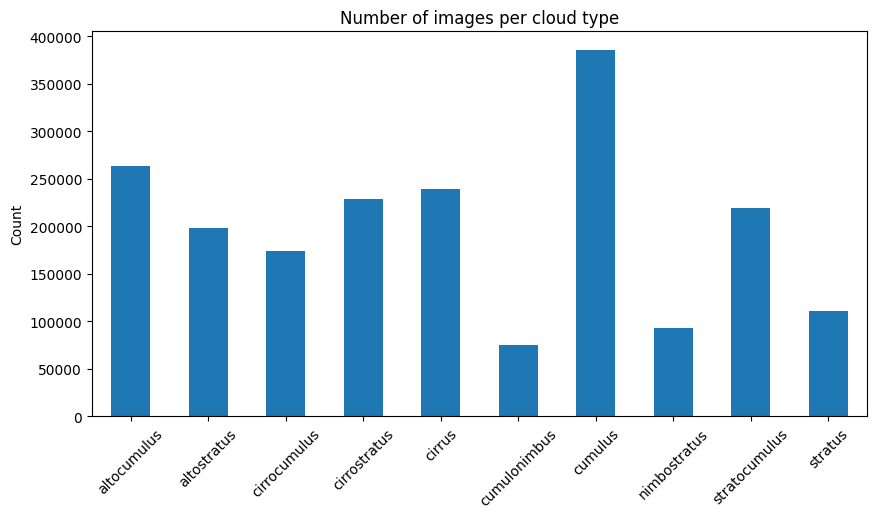

In [92]:
df_imgs_per_cloud(df)

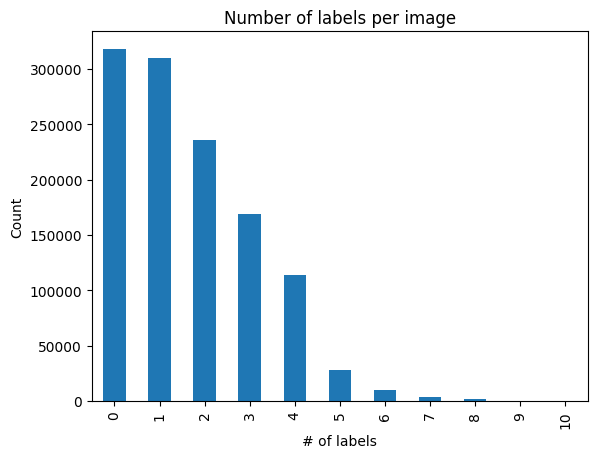

Mean number of labels: 1.671128797930239


In [93]:
df_labels_per_img(df)

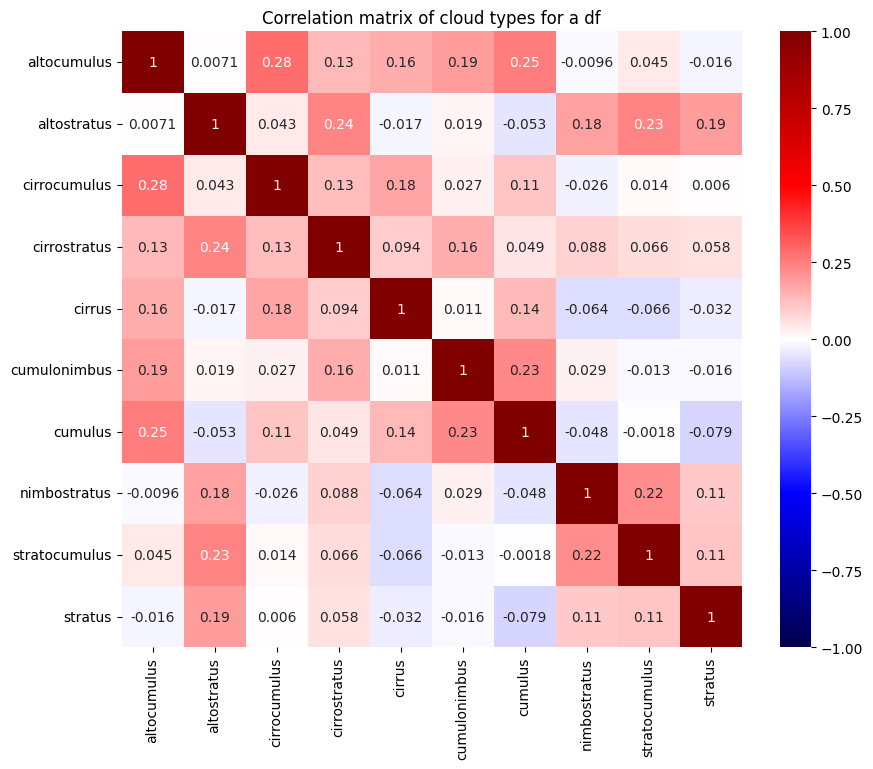

In [94]:
df_corr_matrix(df)

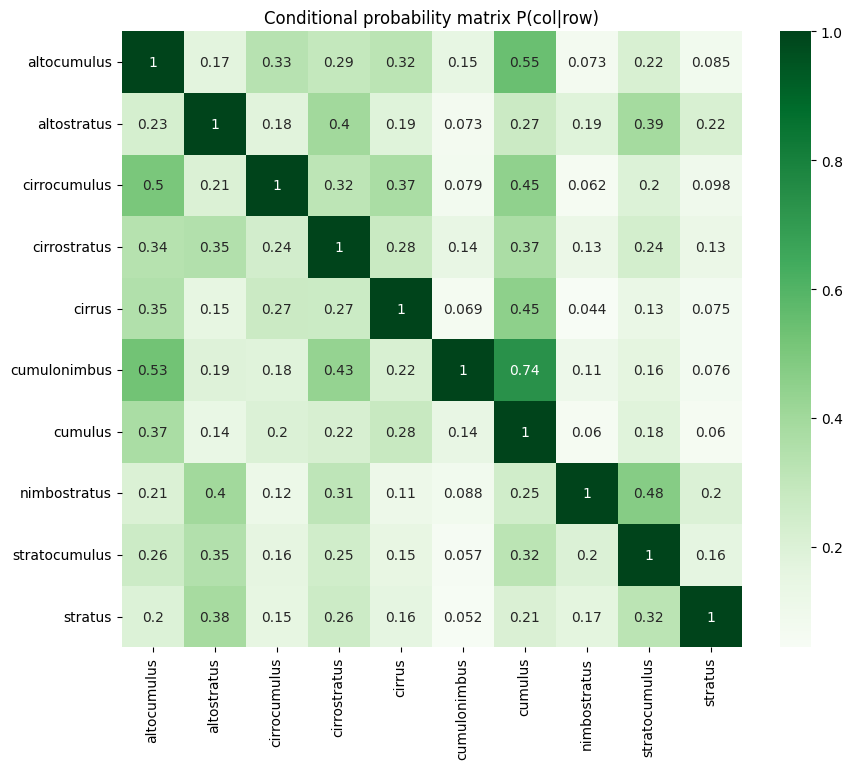

In [95]:
df_cond_prob_matrix(df)

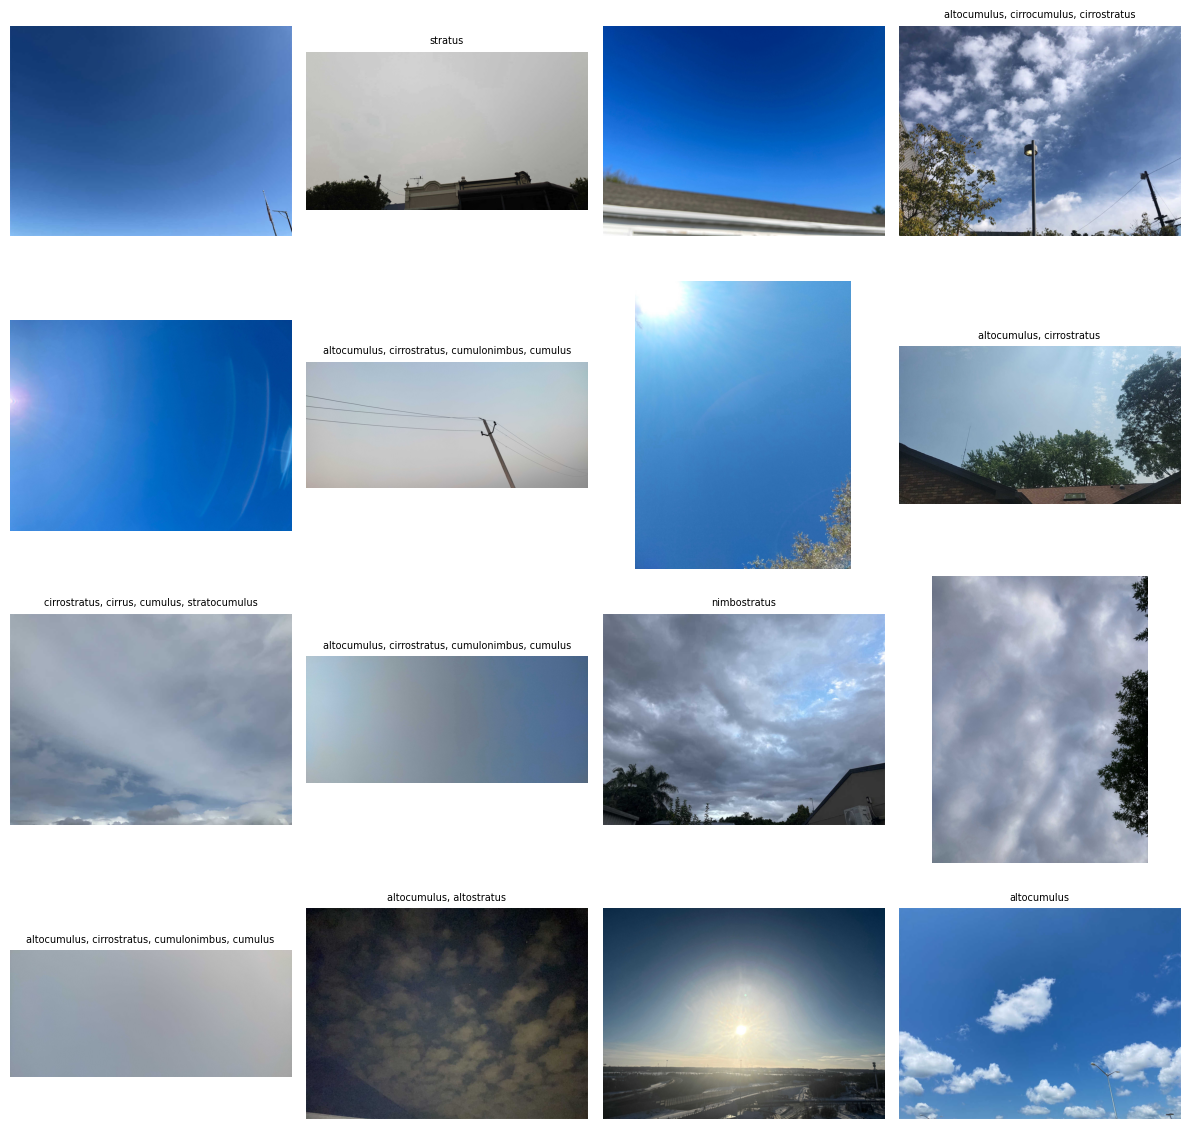

In [96]:
sample_df_subs(df)

In [97]:
from tqdm import tqdm

num_pics = {}
for _, row in df.iterrows():
    user_id = row['user_id']
    num_pics[user_id] = num_pics.get(user_id, 0) + 1

keys = list(num_pics.keys())
keys.sort(key=lambda k: num_pics[k], reverse=True)

for key in keys[:30]:
    print(f"{key}: {num_pics[key]}")

59830782: 31049
6356348: 20741
47406501: 16894
28787031: 14094
42695752: 14055
39805219: 12963
19832726: 12560
41194185: 10555
35497537: 10309
62201928: 10204
47507298: 9998
31783502: 8339
20826653: 8167
94921739: 7819
81757634: 7580
62964956: 7183
24905746: 6680
3151957: 6344
81352292: 5836
85877165: 5782
81975414: 5686
40333849: 5663
65015512: 5312
116058094: 5299
85884796: 5295
80110693: 5260
20085854: 5254
98756347: 5086
51817513: 4867
105804436: 4567


In [98]:
trusted_users = [id for id in df['user_id'] if 6000 > num_pics[id]]

df_trusted = df[df['user_id'].isin(trusted_users)]
df_untrusted = df[~df['user_id'].isin(trusted_users)]

print(len(df_trusted), len(df_untrusted))

974555 215534


/tmp/ipython-input-4287007931.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["num_labels"] = df[CLOUD_COLS].sum(axis=1)


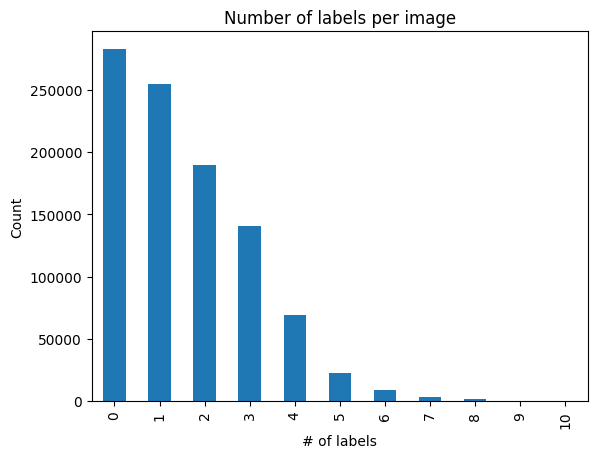

Mean number of labels: 1.5838418560265968


/tmp/ipython-input-4287007931.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["num_labels"] = df[CLOUD_COLS].sum(axis=1)


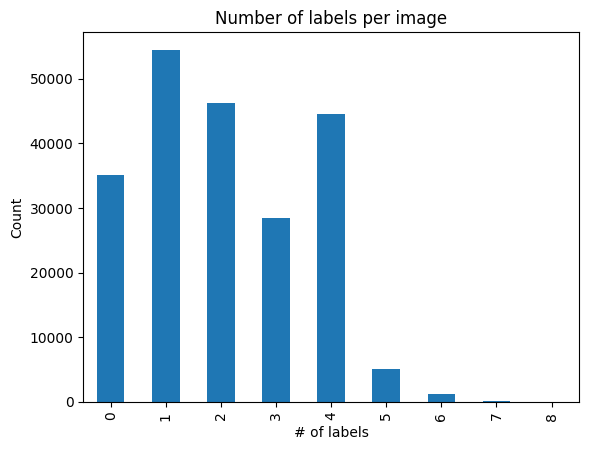

Mean number of labels: 2.0658040030807205


In [99]:
df_labels_per_img(df_trusted)
df_labels_per_img(df_untrusted)

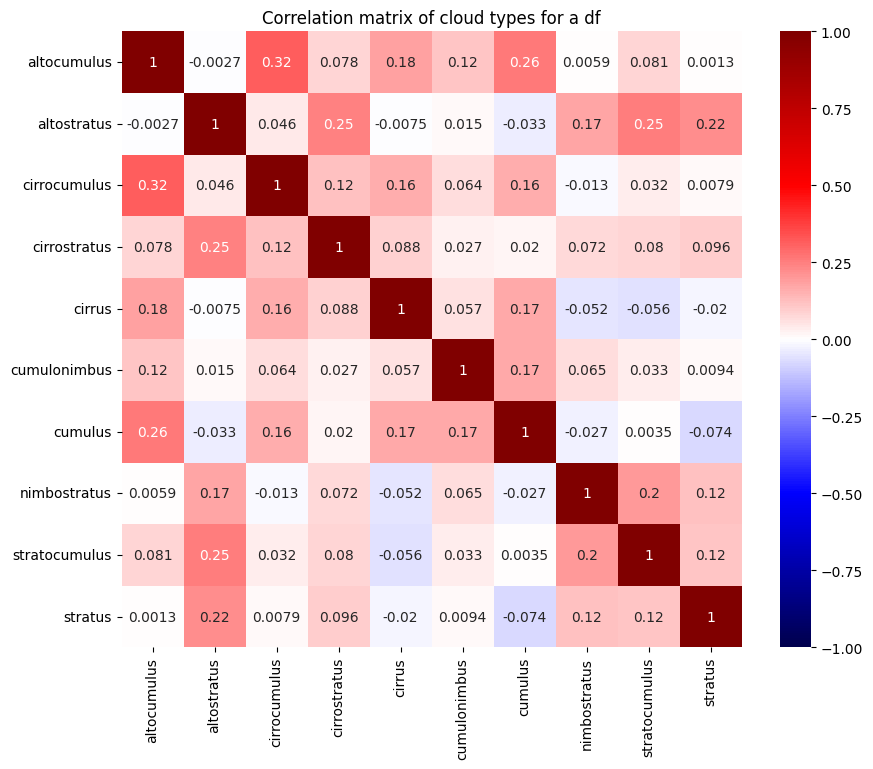

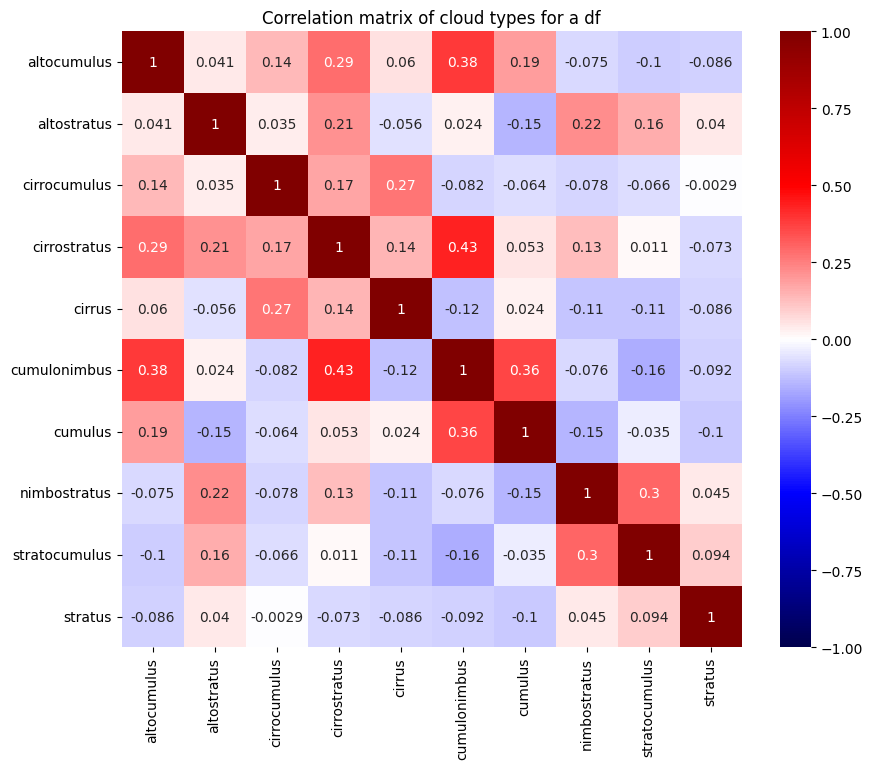

In [100]:
df_corr_matrix(df_trusted)
df_corr_matrix(df_untrusted)

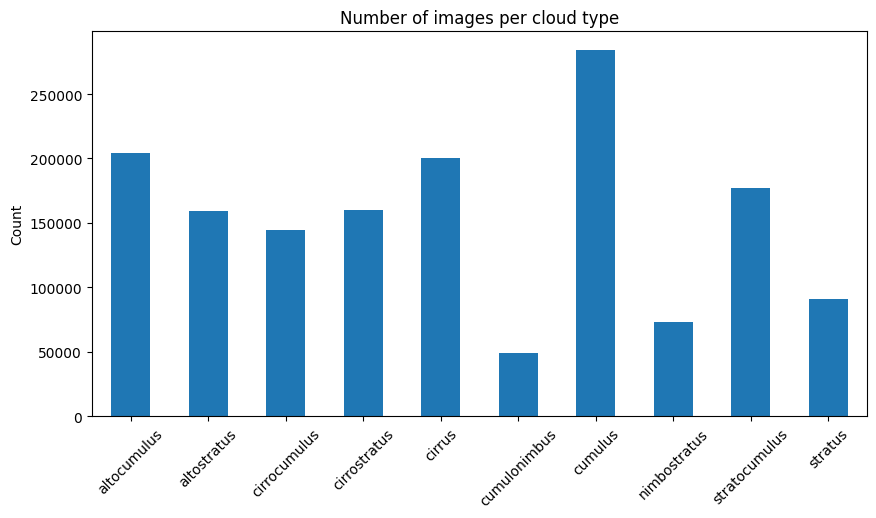

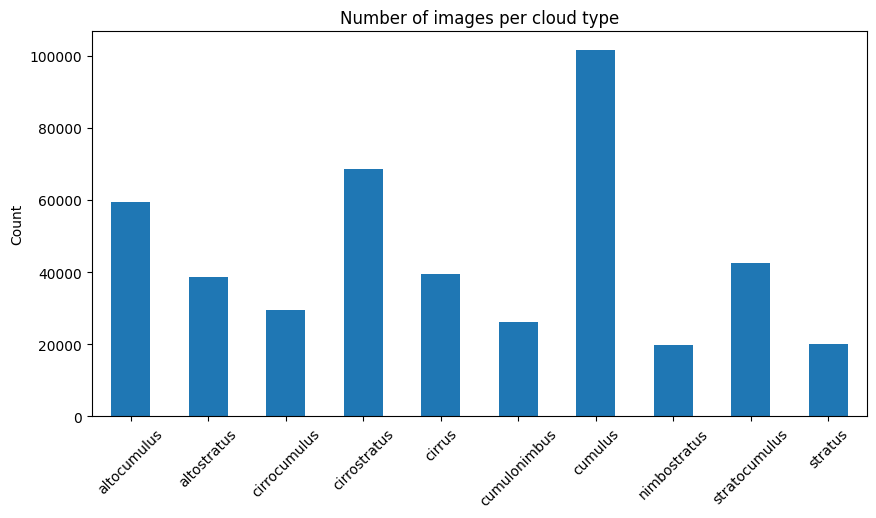

In [101]:
df_imgs_per_cloud(df_trusted)
df_imgs_per_cloud(df_untrusted)

In [107]:
import os, io, hashlib, requests
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import pandas as pd
from tqdm.auto import tqdm

In [103]:
# df_pool = df_trusted.dropna(subset=["photo_url"]).drop_duplicates(subset=["photo_url"]).reset_index(drop=True)

# N = 10_000
# df10k = df_pool.sample(min(N, len(df_pool)), random_state=42).reset_index(drop=True)

# df10k.to_csv(f"{DATA_PROCESSED}/sample_10k_urls.csv", index=False)
# len(df10k)

10000

In [104]:
# DRIVE_IMG_DIR = Path("/content/drive/MyDrive/clouds-ml/data/images_10k")
# DRIVE_IMG_DIR.mkdir(parents=True, exist_ok=True)

# session = requests.Session()

# def url_to_jpg(url: str, dest_dir: Path) -> Path | None:
#     try:
#         h = hashlib.sha1(url.encode("utf-8")).hexdigest()[:20]
#         fp = dest_dir / f"{h}.jpg"
#         if fp.exists():
#             return fp
#         r = session.get(url, timeout=15)
#         r.raise_for_status()
#         img = Image.open(io.BytesIO(r.content)).convert("RGB")
#         img.save(fp, format="JPEG", quality=90)
#         return fp
#     except Exception as e:
#         print(f"[skip] {url} -> {e}")
#         return None

# local_files = []
# for url in tqdm(df10k["photo_url"].tolist(), desc="Downloading 10k images"):
#     fp = url_to_jpg(url, DRIVE_IMG_DIR)
#     local_files.append(fp.name if fp is not None else None)

# df10k["download_name"] = local_files
# df10k = df10k.dropna(subset=["download_name"]).reset_index(drop=True)
# len(df10k)

10000

In [109]:
df10k = pd.read_csv(f"{DATA_PROCESSED}/sample_10k_urls.csv")
df10k.head()

,Unnamed: 0,photo_url,direction,obs_id,user_id,globe_trained,citizen_science,altocumulus,altostratus,cirrocumulus,cirrostratus,cirrus,cumulonimbus,cumulus,nimbostratus,stratocumulus,stratus,local_path,num_labels
0,332814,https://data.globe.gov/system/photos/2024/11/0...,N,116-365514-136107076-202411091439,136107076,0,1,1,1,0,0,0,0,0,0,0,0,NaN,2
1,404477,https://data.globe.gov/system/photos/2024/09/1...,S,116-111679-40333849-202409101507,40333849,0,1,0,0,1,0,0,0,0,0,0,0,NaN,1
2,1074697,https://data.globe.gov/system/photos/2022/12/0...,E,116-265214-85897343-202212082124,85897343,0,1,1,0,1,0,1,0,1,0,0,0,NaN,4
3,361227,https://data.globe.gov/system/photos/2024/10/1...,E,116-297313-138640393-202410162110,138640393,0,1,0,0,0,0,0,0,0,0,1,0,NaN,1
4,216605,https://data.globe.gov/system/photos/2025/03/0...,E,116-373941-23555985-202503052232,23555985,0,1,0,0,0,0,0,0,1,0,1,1,NaN,3


In [111]:
# --- Robust Step 3: (re)create download_name from the URL deterministically ---
import os, hashlib
from pathlib import Path
from config import BASE_DIR, DATA_PROCESSED

# If you don't still have df10k in memory, reload the sampled URLs:
# df10k = pd.read_csv(f"{DATA_PROCESSED}/sample_10k_urls.csv")

def name_from_url(url: str) -> str:
    h = hashlib.sha1(url.encode("utf-8")).hexdigest()[:20]
    return f"{h}.jpg"

# Make/restore the column regardless of prior steps
df10k["download_name"] = df10k["photo_url"].astype(str).map(name_from_url)

# Where images were saved in Drive in Step 2
DRIVE_IMG_DIR = Path("/content/drive/MyDrive/clouds-ml/data/images_10k")

# Build local_path (relative to project) to match your pipeline
df10k["local_path"] = "data/images_10k/" + df10k["download_name"]

# Full path on Drive (BASE_DIR comes from your config.py)
df10k["full_path"] = df10k["local_path"].apply(lambda p: os.path.join(BASE_DIR, p))

# Keep only rows whose file actually exists on Drive (in case of failed downloads)
df10k = df10k[df10k["full_path"].apply(lambda p: isinstance(p, str) and os.path.isfile(p))].reset_index(drop=True)
print("Drive files found:", len(df10k))

# Mirror to /content for faster I/O
!mkdir -p /content/images_10k
!rsync -a --info=progress2 "/content/drive/MyDrive/clouds-ml/data/images_10k/" "/content/images_10k/"

# Rewrite full_path to /content (same pattern your training script uses)
df10k["full_path"] = df10k["full_path"].str.replace(
    "/content/drive/MyDrive/clouds-ml/data/images_10k",
    "/content/images_10k",
    regex=False
)

# Keep only rows whose VM path exists
df10k = df10k[df10k["full_path"].apply(lambda p: isinstance(p, str) and os.path.isfile(p))].reset_index(drop=True)
print("VM files ready:", len(df10k))

# Save the final CSV your DataLoader can consume
df10k.to_csv(f"{DATA_PROCESSED}/sample_10k_ready.csv", index=False)

Drive files found: 10000
  3,175,828,403 100%    9.92MB/s    0:05:05 (xfr#10000, to-chk=0/10001)
VM files ready: 10000


In [112]:
import os, math, random, time
import pandas as pd
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.amp import GradScaler, autocast

from tqdm.auto import tqdm
from config import BASE_DIR, DATA_PROCESSED, MODELS_DIR

Exception ignored in: <function tqdm.__del__ at 0x7d4875c98cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/lib/python3.12/dist-packages/tqdm/std.py", line 1277, in close
    if self.last_print_t < self.start_t + self.delay:
       ^^^^^^^^^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'last_print_t'


In [113]:
CSV_PATH  = os.path.join(DATA_PROCESSED, "sample_10k_ready.csv")
SAVE_PATH = os.path.join(MODELS_DIR, "resnet18_big.pth")
os.makedirs(MODELS_DIR, exist_ok=True)

In [114]:
df = pd.read_csv(CSV_PATH)
def to_full(p: str | None):
    if isinstance(p, str):
        return os.path.join(BASE_DIR, p)
    return None

df["full_path"] = df["local_path"].apply(to_full)
df["full_path"] = df["full_path"].str.replace(
    "/content/drive/MyDrive/clouds-ml/data/images_10k", "/content/images_10k", regex=False
)
df = df[df["full_path"].apply(lambda p: isinstance(p, str) and os.path.isfile(p))].reset_index(drop=True)

In [115]:
CLOUD_COLS = [
    "altocumulus","altostratus","cirrocumulus","cirrostratus",
    "cirrus","cumulonimbus","cumulus","nimbostratus","stratocumulus","stratus"
]
num_classes = len(CLOUD_COLS)

class CloudDataset(Dataset):
    def __init__(self, df, transform=None):
        self.paths  = df["full_path"].tolist()
        self.labels = df[CLOUD_COLS].to_numpy(dtype=np.float32)
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, torch.from_numpy(self.labels[i])

img_size = 224
train_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.03),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
val_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_frac = 0.2
val_size = int(len(df) * val_frac)
train_size = len(df) - val_size
g = torch.Generator().manual_seed(42)
indices = torch.randperm(len(df), generator=g).tolist()
train_idx, val_idx = indices[:train_size], indices[train_size:]

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df   = df.iloc[val_idx].reset_index(drop=True)

train_ds = CloudDataset(train_df, transform=train_tfms)
val_ds   = CloudDataset(val_df,   transform=val_tfms)

batch_size = 64
use_cuda = torch.cuda.is_available()
train_dl = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=use_cuda, persistent_workers=True, prefetch_factor=2
)
val_dl = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=use_cuda, persistent_workers=True, prefetch_factor=2
)

print(f"Train: {len(train_ds)}  |  Val: {len(val_ds)}  |  Batch: {batch_size}")


Train: 8000  |  Val: 2000  |  Batch: 64


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [116]:
device = torch.device("cuda" if use_cuda else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, num_classes)
model = model.to(device)

criterion  = nn.BCEWithLogitsLoss()
optimizer  = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler  = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

torch.backends.cudnn.benchmark = True
scaler = GradScaler(enabled=use_cuda, device="cuda")

@torch.no_grad()
def evaluate(model, dl, thresh=0.5):
    model.eval()
    total_loss, n_samples = 0.0, 0
    correct_per_label = torch.zeros(num_classes, dtype=torch.long)
    total_per_label   = torch.zeros(num_classes, dtype=torch.long)
    exact_correct = 0

    for imgs, labels in dl:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        total_loss += loss.item() * imgs.size(0)
        n_samples  += imgs.size(0)

        preds = (logits.sigmoid() >= thresh).long()
        correct_per_label += (preds == labels.long()).sum(dim=0).cpu()
        total_per_label   += torch.tensor([imgs.size(0)] * num_classes)
        exact_correct     += (preds.eq(labels.long()).all(dim=1)).sum().item()

    avg_loss = total_loss / max(1, n_samples)
    per_label_acc = (correct_per_label.float() / total_per_label.clamp(min=1).float()).tolist()
    exact_match = exact_correct / max(1, n_samples)
    return avg_loss, per_label_acc, exact_match

epochs = 5
best_val = float('inf')

for epoch in range(1, epochs+1):
    model.train()
    pbar = tqdm(train_dl, desc=f"Epoch {epoch}/{epochs}", leave=False)
    running_loss, n_seen = 0.0, 0

    for imgs, labels in pbar:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with autocast("cuda", enabled=use_cuda, dtype=torch.float16):
            logits = model(imgs)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        n_seen += imgs.size(0)
        pbar.set_postfix(train_loss=f"{running_loss / max(1, n_seen):.4f}")

    val_loss, per_label_acc, exact_match = evaluate(model, val_dl, thresh=0.5)
    scheduler.step(val_loss)

    print(f"[Epoch {epoch}] val_loss={val_loss:.4f}  exact_match={exact_match:.4f}")
    short = {lbl: f"{acc:.3f}" for lbl, acc in zip(CLOUD_COLS, per_label_acc)}
    print(" per-label acc:", short)

torch.save({
    "model": model.state_dict(),
    "labels": CLOUD_COLS,
    "epoch": epochs
}, SAVE_PATH)

print(f"Saved final model to {SAVE_PATH}")

print("Done.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


Epoch 1/5:   0%|          | 0/125 [00:00<?, ?it/s]

KeyboardInterrupt: 